In [1]:

import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
8e-4*2/3 /52

1.0256410256410258e-05

In [129]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys


if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
fmt = lambda x, pos: '{:.3f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

# sns.set(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 25
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40

In [128]:
sns.reset_defaults()

In [4]:
def model(X, t, R0, kappa):
        x = X[0]
        y = X[1]
        z = X[2]
        dxdt = - R0/(1+kappa * y) *x * y
        dydt =  R0/(1+kappa* y) * x * y - y
        dzdt = y
        return [dxdt, dydt, dzdt]


In [5]:
import pandas as pd
import scipy.interpolate as spi



In [6]:
@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

In [7]:
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)


In [8]:
nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
nb_name= nb_name[:nb_name.find('.ipynb')]

obsidian_vault_folder = os.path.expanduser("~")+'/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree/'
figures_folder = obsidian_vault_folder + '/figures/'+nb_name+'/'
os.makedirs(figures_folder,exist_ok=True)

In [9]:
import cProfile

In [10]:
rnd.seed(101)
random.seed(101)

In [11]:
N = 1e7
R0=beta=3
mu= 1e-4
p_alpha = .1
kappa=0
xi = 50


In [12]:
mu

0.0001

In [13]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [14]:
%load_ext autoreload

In [120]:
%autoreload
M_controlled = eqModel(N=N, infection_rate=beta, kappa= 1e3, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_controlled.run_to_extinction()#(ignore_running= True,max_iter = 6000)
print('done')

  2%|▏         | 7808/381890 [00:09<07:39, 813.61it/s] 

done


In [16]:
ilast = M_controlled.ilast

delta_i = 1000

12174

In [122]:
delta_i = 1000
for i in tqdm(range(M_controlled.ilast,M_controlled.ilast+delta_i)):
    M_controlled.step()
    if i%10 == 0:
        M_controlled.snapshot(i*M_controlled.dt)
M_controlled.ilast += delta_i

100%|██████████| 1000/1000 [00:02<00:00, 343.06it/s]


In [18]:

print(f'{mu:.1e}')

1.0e-04


In [146]:
ds = np.arange(0,20 + np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,1,figsize=(15,8),sharex=True)
ax = [ax]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = M_controlled.find_x_inf(R0,kappa)
T = M_controlled.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(M_controlled.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(M_controlled.root_strain.times)
    I_root = np.array(M_controlled.root_strain.infected_history)
    S_root = np.array(M_controlled.root_strain.susceptible_history)
    R_root = np.array(M_controlled.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in M_controlled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # #ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # #ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        #ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        #ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # #ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    #ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


for a in ax:
    a.set_xlabel('Time')
    
# ax[0].set_title('$y(t)$',pad=20)
# ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
# ax[0].set_ylim((1/N,1))

#ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
#ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

#ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
# norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                # cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')
plt.savefig(output_folder+'infection_trajectory_competition.svg',bbox_inches='tight')
# plt.show()

In [104]:
%autoreload
M_controlled_2 = eqModel(N=N, infection_rate=beta, kappa= 1e3, recovery_rate=1, mutation_rate = mu/10, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_controlled_2.run_to_extinction()#(ignore_running= True,max_iter = 6000)
print('done')

ilast = M_controlled_2.ilast
delta_i = 1000
for i in tqdm(range(ilast,ilast+delta_i)):
    M_controlled_2.step()
    if i%10 == 0:
        M_controlled_2.snapshot(i*M_controlled_2.dt)


%autoreload
M_controlled_2b = eqModel(N=N, infection_rate=beta, kappa= 1e3, recovery_rate=1, mutation_rate = mu/10, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_controlled_2b.run_to_extinction()#(ignore_running= True,max_iter = 6000)
print('done')

ilast = M_controlled_2b.ilast
delta_i = 1000
for i in tqdm(range(ilast,ilast+delta_i)):
    M_controlled_2b.step()
    if i%10 == 0:
        M_controlled_2b.snapshot(i*M_controlled_2b.dt)

  4%|▍         | 16294/381890 [00:01<00:44, 8290.55it/s] 


done


  6%|▌         | 22334/381890 [00:03<00:51, 6974.45it/s]


done


100%|██████████| 1000/1000 [00:00<00:00, 3961.73it/s]


In [154]:
plt.rcParams['font.family'] = 'sans-serif'  # or any other font you prefer
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']

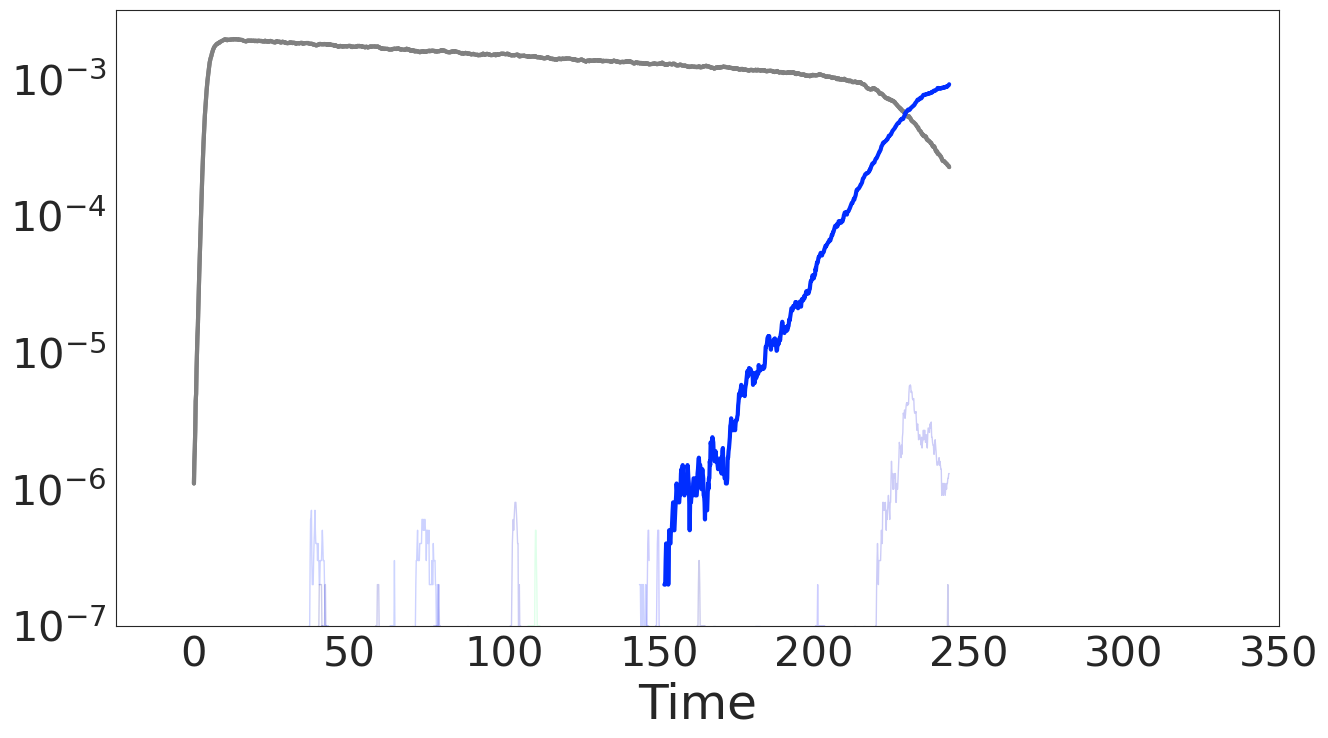

In [155]:
ds = np.arange(0,20 + np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,1,figsize=(15,8),sharex=True)


ax = [ax]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = M_controlled_2.find_x_inf(M_controlled_2.infection_rate,M_controlled_2.kappa)
T = M_controlled_2.calc_T(M_controlled_2.infection_rate,M_controlled_2.kappa,M_controlled_2.N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(M_controlled_2.infection_rate,M_controlled_2.kappa)).T


# ax[0].plot(ts_det,y,color='k',ls='--',label='Deterministic')

#get the three strains with the highest infected size
big_strains = sorted(M_controlled_2.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(M_controlled_2.root_strain.times)
    I_root = np.array(M_controlled_2.root_strain.infected_history)
    S_root = np.array(M_controlled_2.root_strain.susceptible_history)
    R_root = np.array(M_controlled_2.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in M_controlled_2.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # #ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # #ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        #ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        #ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # #ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    #ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


for a in ax:
    a.set_xlabel('Time')
    
# ax[0].set_title('$y(t)$',pad=20)
# ax[0].set_ylabel('Infected fraction')
ax[0].set_xlim((-25,350))

ax[0].set_yscale('log')
# ax[0].set_xlim((-100,2000))
# ax[0].set_ylim((1/N,1))

#ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
#ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

#ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha



plt.savefig(output_folder+'traj_1.svg',bbox_inches='tight')
plt.show()

In [148]:
ds = np.arange(0,20 + np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,1,figsize=(15,8),sharex=True)
ax = [ax]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = M_controlled_2b.find_x_inf(R0,kappa)
T = M_controlled_2b.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(M_controlled_2b.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(M_controlled_2b.root_strain.times)
    I_root = np.array(M_controlled_2b.root_strain.infected_history)
    S_root = np.array(M_controlled_2b.root_strain.susceptible_history)
    R_root = np.array(M_controlled_2b.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in M_controlled_2b.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # #ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # #ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        #ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        #ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # #ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    #ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


for a in ax:
    a.set_xlabel('Time')
    
# ax[0].set_title('$y(t)$',pad=20)
# ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
# ax[0].set_ylim((1/N,1))
ax[0].set_xlim((-25,350))
#ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
#ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

#ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha

plt.savefig(output_folder+'traj_2.svg',bbox_inches='tight')

In [107]:
Ms_controlled = [M_controlled_2,M_controlled_2b]

In [141]:
fig,axes = plt.subplots(2,1,figsize=(20,15),sharex=True)

for i, ax in enumerate(axes):
    big_strains = sorted(Ms_controlled[i].strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
    big_names=  [strain.name for strain in big_strains]

    if True:
        ts_root= np.array(Ms_controlled[i].root_strain.times)
        I_root = np.array(Ms_controlled[i].root_strain.infected_history)
        S_root = np.array(Ms_controlled[i].root_strain.susceptible_history)
        R_root = np.array(Ms_controlled[i].root_strain.recovered_history)
        xparent = S_root/N
        zparent = R_root/N
        yparent = I_root/N
        t_peak = ts_root[np.argmax(I_root)]
        legend_ds = {}

    for strain in Ms_controlled[i].strain_set:
        if strain.name==0:
            color='grey'
        else:
            color = color_ds[strain.distance_to_parent]

        I_i = np.array(strain.infected_history)
        if len(I_i)==0:
            continue

        c= np.exp(-strain.distance_to_parent/xi)
        s_inf = R0*(1-xinf)*(1-c)
        

        chi_i = np.array(strain.frequency_history)
        s_i = np.array(strain.selection_history)
        ts_i = np.array(strain.times)
        d_pc = strain.distance_to_parent
        
        if strain.root_intersection_time<np.inf or strain.name==0:
            
            # #ax[1].axhline(s_inf,color=color,ls='--')
            t_i0 = ts_i[0]
            chi_0 = chi_i[0]
            if t_i0<t_peak:
                t_i0 = t_peak

                # ax.axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
            
            # ax.axhline(chi_0,color=color,ls='--')
            # ax.plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
            alpha= 1
            lw= 3
            # #ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
            #ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
            #ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
            # #ax[1].plot(ts)

        else: 
            alpha = .2
            lw= 1
        if strain.name ==0:
            ax.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
        ax.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
        #ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


# for a in ax:
#     a.set_xlabel('Time')
    
# ax.set_title('$y(t)$',pad=20)
# ax.set_ylabel('Infected fraction')
    ax.set_yscale('log')
    # ax.set_ylim((1/N,1))
    ax.set_xlim((-25,350))
    #ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
#ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

#ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax.set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha

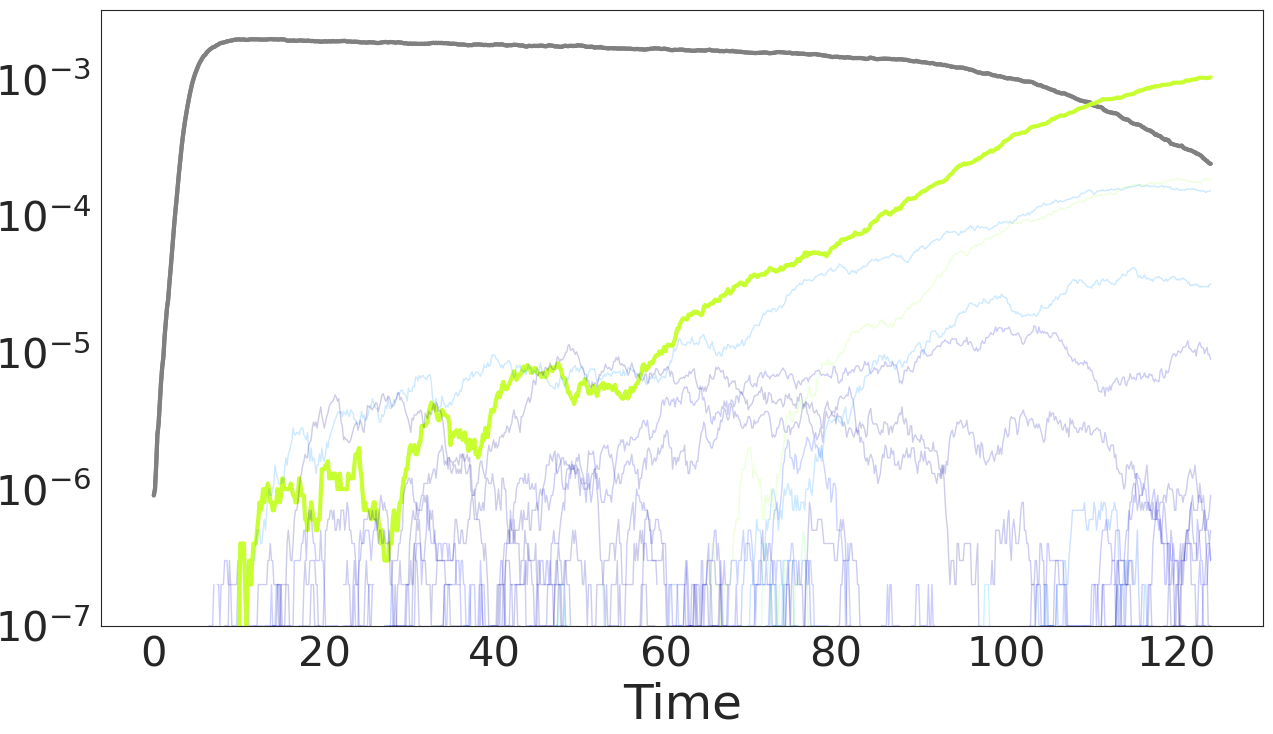

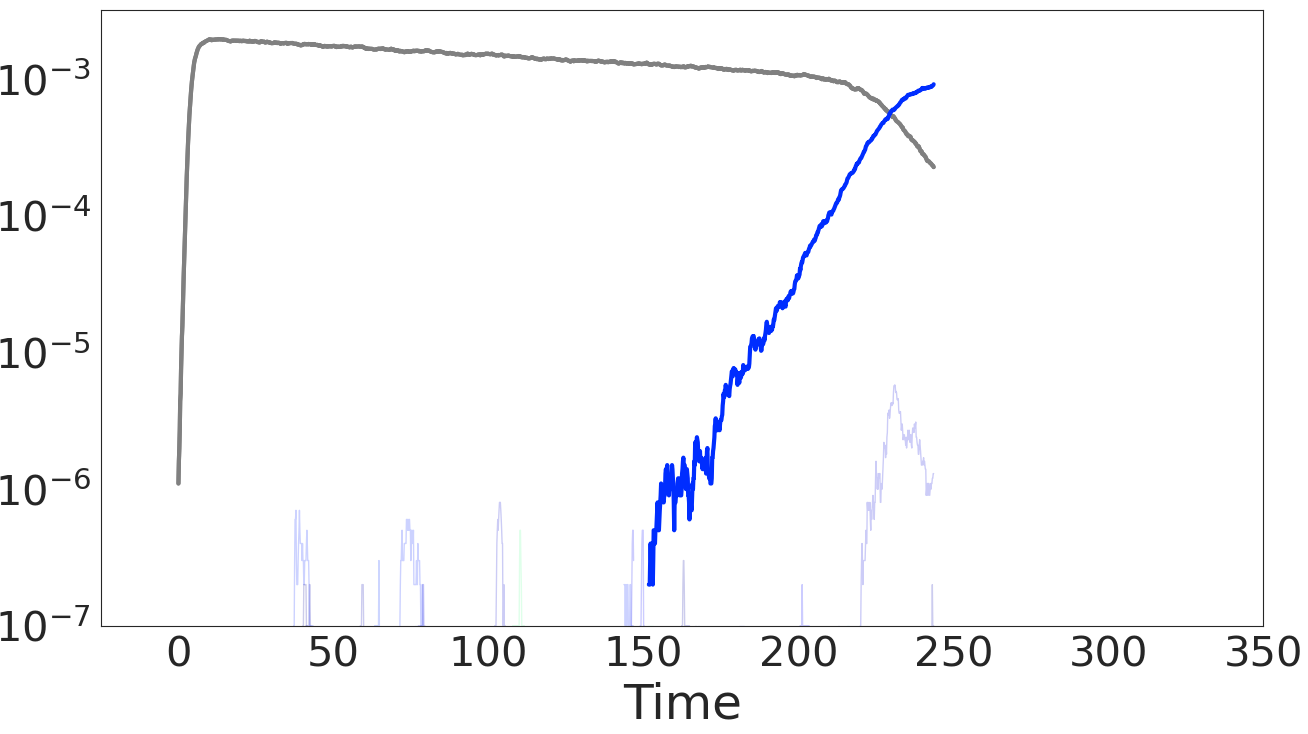

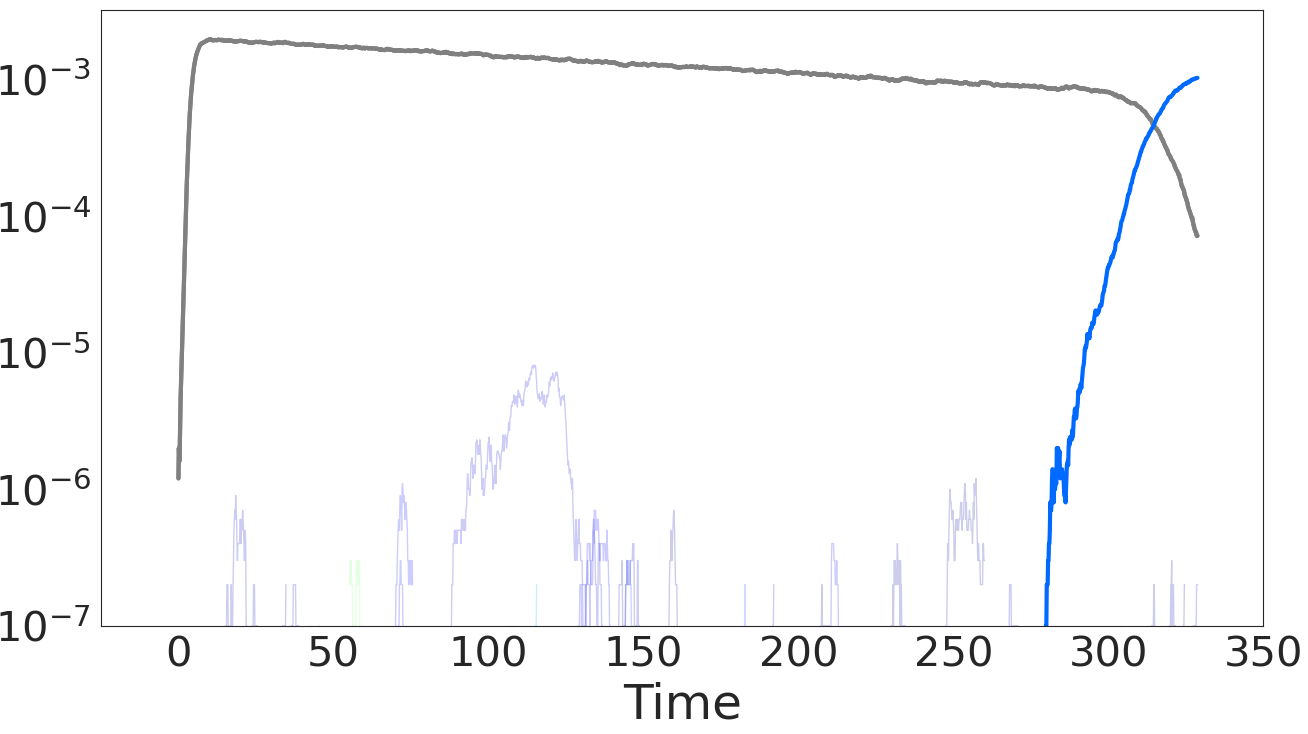

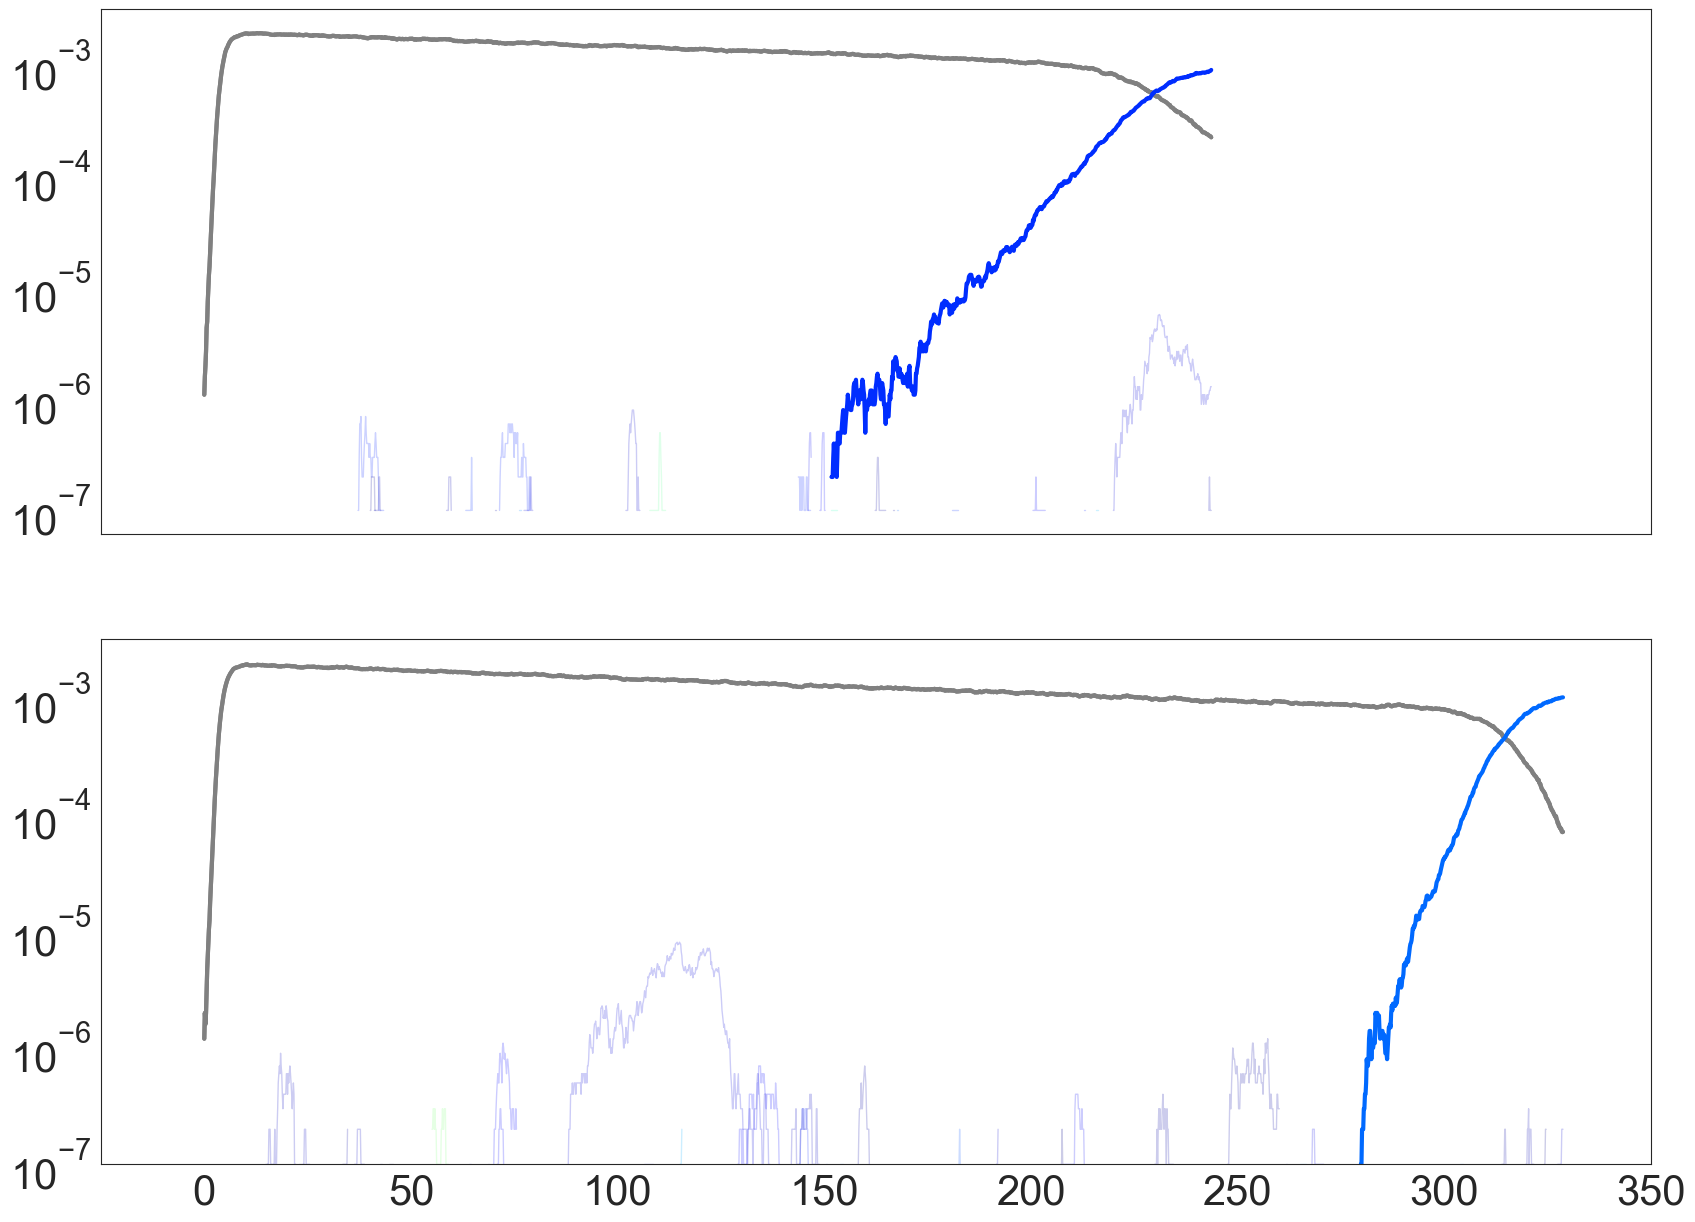

In [142]:
def plot_strain(strain, ax_n, ax_sel, color_ds, xi, R0, xinf, t_peak, N):
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        return 0
    d_pc = strain.distance_to_parent
    c= np.exp(-d_pc/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax_n.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)

plt.show()